# Modeling Report

## Summary

- 事前学習済みResNetモデルでf1 score 0.9と悪くない性能のモデルが得られた
- 小さいデータセットからモデルを学習させるため、cosine lossやweight pruningなどの対策を行ったが、効果がなかった。
- 一部の欠陥は違いがわずかで、検知できなかった。

## METHOD

### タスクのタイプ

２クラス分類としてとらえ、NO(0)とOK(1)に分類した。  
今回クラス分布に特に偏りがないため、0と1の振り方には意図はない。  

### モデル性能の評価方法

hold-out法（train: test= 8 : 2）を利用し行った。クラス分布はそれぞれソースと同じものに分割した。  

trainデータをさらに8:2に分割し、後者をvalidationに用いた。時間の関係でk-fold法は用いなかった。  
評価指標は以下のものを用いた。  

- F1-Score
    precision/recallの両方を考慮して性能を評価するため。
- roc-auc 
    出力されたクラス確率をクラスに変換する閾値に関わらず、  
    より確実に２クラスを区別して分類できているか確認するため。
    
### base model architecture

PyTorch組み込みのResNet 50モデルを用いた。  
選定理由としては以下の通りである。

- 転移学習を利用できる
    今回データセットに含まれるサンプル数が400に満たず、機械学習の分類モデルを作成するには比較的少ない。
    そこでより大きなデータセットで訓練した結果をfine-tunningにより利用できるdeep learningを選んだ。

- 畳み込み層・プーリング層により空間的な関係を考慮した特徴量を抜き出せる
    データセットの画像に移っている箱は、傾きや箱までの距離が異なる。  
    それらを無視して、目的の欠陥のクラスによる違いだけを判別させるために、  
    空間的な関係を考慮できるCNNを利用した。  
    
- 深い層により、複雑な特徴を抽出できる
    NGとされた画像には、破れやへこみ、汚れなど欠陥の形が一定でない。  
    それらの一定ではない欠陥の特徴を抜き出すためにより深い層のモデルであるResNetを利用した。  

ただし、ResNetは比較的サイズの大きいモデルであるため、　
学習・推論に時間がかかったり、小さいリソースのマシンでは利用できない可能性がある。  
しかし今回特に制約がなかったため、その点は考慮していない。  

### 作成したモデル

今回は以下の3種類のモデルを作成し、比較した。  

1. "resnet50_pretrained"
    事前学習済みResNet50モデル。loss funcitonはcross entropy loss
    
2. "resnet50_pretrained_cosine"
    事前学習済みResNet50モデル。loss funcitonはcosine loss
    
3. "resnet50_pretrained_cosine_pruned"
    model2からweight pruningを行ったもの。

### pretraining

Imagenetによる事前学習済みResNet50（pytorch(torchvision)に組み込み）を用いた。  

### 小さいデータセットから学習するための工夫

前述のように今回データセット内のサンプル数が400以下と画像分類モデルを学習させるには少ない。  
そこで以下のような工夫を行った。

**model archetecture / hyperparameters**

1. fine-tuning (model1, 2, 3)  
    前述の通り事前学習済みResNet50をfine-tuningして利用した。  
    元の出力層の後に、全結合層を2層(それぞれ16, 2ユニット)追加し、追加部分のパラメータのみを学習させた。  
    大部分のパラメータを凍結したのは、パラメータ数がサンプル数より大きくなることで、  、  
    オーバーフィットが起こることを避けるためである。  
    なお、normalizationの際データ分布をimagenetと同じになるようにそろえた。
    
2. drop out (model1, 2, 3)   
    全結合層間のドロップアウトによりオーバーフィットを防いだ。
    
3. weight pruning (model3)  
    optimizerのweight decay（l2 normalization）により、重要度の低い成分の重みの大きさを抑えている。
    そのため後述するように、全結合層のweightの中には比較的小さい成分も多く見られた。  
    そこでさらに積極的にモデルの複雑性を減らすために、weightの成分のpruningを行った。  
    model3では、model2からweight pruningを行って再度訓練させた。  
    
**optimze**

1. small batch size (model1, 2, 3)
    サンプルサイズが小さいため、ミニバッチのサイズが大きいとパラメータの更新回数が少なく、  
    一部のバッチ内のデータの偏りに大きく影響を受ける可能性がある。  
    そこでbatch sizeは32と、比較的小さめにした。  
    
3. cosine loss (model2, 3)  
    文献1によると、loss functionにcross entropyの代わりにcosine lossを用いると、
    小さいデータセットに対してパフォーマンスが改善するとある。  
    そのため、cosine lossで訓練を行ったモデルも作成した。  
    
**augmentation**

サンプル数の不足を補い、よりロバストなモデルを作成するため以下のdata augmentationを行った。

1. RandomResizedCrop
    箱が画像のかなりの割合を占めるため、croppingのサイズは0.85~1.0と大きめに行った。  
2. RandomHorizontalFlip




## Result and Discussion

### weightの分布とpruning

パラメータを分析するためにmodel2の最後の２層の全結合層(not-frozen-1, not-frozen-2)のweightと分布を示す。

In [76]:
import pandas as pd

In [77]:
import torch

In [79]:
state_dict = torch.load("../output/resnet50_pretrained_cosine/holdout/model", map_location="cpu")

In [80]:
not_frozen_layers = [state_dict['2.weight'], state_dict['4.weight']]

In [81]:
for layer in not_frozen_layers:
    print(layer.shape)

torch.Size([16, 1000])
torch.Size([2, 16])


In [82]:
not_frozen_layers = [layer.cpu().numpy() for layer in not_frozen_layers]

In [83]:
not_frozen_layers = [layer.flatten() for layer in not_frozen_layers]

In [84]:
import seaborn as sns

In [85]:
import numpy as np

In [86]:
import pandas as pd

#### not-frozen-1

In [88]:
pd.DataFrame(pd.Series(not_frozen_layers[0].ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,16000.0,-0.000071,0.064796,-0.395303,-0.036899,-0.000077,0.036077,0.356364


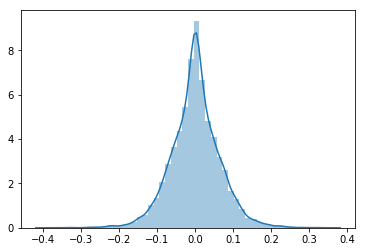

In [90]:
sns.distplot(not_frozen_layers[0])

In [89]:
pd.DataFrame(pd.Series(np.abs(not_frozen_layers[0]).ravel()).describe(percentiles=[0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95])).transpose()

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
0,16000.0,0.047871,0.043666,0.000005,0.002395,0.005115,0.014352,0.036469,0.06941,0.105188,0.130429,0.395303


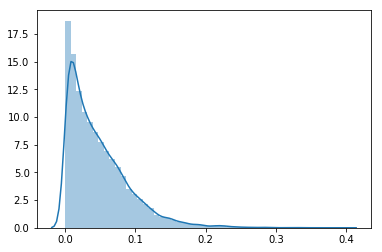

In [91]:
sns.distplot(np.abs(not_frozen_layers[0]))

出力から2番目のfully connected layerでは、重みの分布が正規表現と似ているが、より尖度が大きい分布となっている。  
また重みの絶対値は90%以上が0.002以上となっており、一方約10%が0.1以上の重みをもっている。
比率にすると

In [92]:
0.105188 / 0.005115

20.564613880742915

と大きな重みの差があり、小さな重みを取り除くことでよりロバストなモデルにできる可能性がある。

#### not-frozen-layer-2

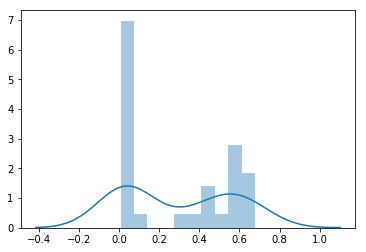

In [93]:
sns.distplot(np.abs(not_frozen_layers[1]), bins=10)

In [94]:
pd.DataFrame(pd.Series(np.abs(not_frozen_layers[1]).ravel()).describe(percentiles=[0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95])).transpose()

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
0,32.0,0.287762,0.265692,0.007434,0.012386,0.020471,0.031714,0.21264,0.557401,0.618944,0.653655,0.679708


最後の出力層weightが0.020以下のものが10%近くを占めており、90パーセンタイルと10パーセントタイルの値の比は

In [95]:
0.653655 / 0.020471

31.93078012798593

30倍以上あるためパラメータをpruningできる可能性がある。

### pruningのパラメータ
以上の結果から、そこでmodel3ではmodel2からnot-frozen-1で0.01、not-frozen-2で0.2以下の重みを取り除いて（0に固定して）、
再度トレーニングを行った。

### evaluation
#### evaluation scores

In [11]:
import pandas as pd
from pathlib import Path

In [32]:
!ls ../output/resnet50_pretrained_cosine/holdout/evaluation/

evaluation_score.csv  train_predicted.csv
test_predicted.csv    valid_predicted.csv


In [9]:
model_names = ["resnet50_pretrained", "resnet50_pretrained_cosine", "resnet50_pretrained_cosine_pruned"]

In [17]:
model_dirs = {name: Path("../output/").joinpath(name) for name in model_names}

In [19]:
model_evaluation_results = {
    name:
    pd.read_csv(path.joinpath("holdout/evaluation/evaluation_score.csv"), index_col=False) for name, path in model_dirs.items()
}

In [27]:
score_summary_dfs = {
    score_name: pd.DataFrame(["train", "valid", "test"], columns=["subset"]) for score_name in ["f1_scores", "roc_auc"] 
}

In [28]:
for score_name, df in score_summary_dfs.items():
    for model_name, result_df in model_evaluation_results.items():
        df[model_name] = result_df[score_name]

In [29]:
print("f1_score")
score_summary_dfs["f1_scores"]

f1_score


,subset,resnet50_pretrained,resnet50_pretrained_cosine,resnet50_pretrained_cosine_pruned
0,train,0.937238,0.916335,0.979253
1,valid,0.950820,0.952381,0.983051
2,test,0.900000,0.880952,0.829268


In [30]:
print("roc_auc")
score_summary_dfs["roc_auc"]

roc_auc


,subset,resnet50_pretrained,resnet50_pretrained_cosine,resnet50_pretrained_cosine_pruned
0,train,0.974861,0.930372,0.996610
1,valid,0.967778,0.963333,0.994444
2,test,0.950213,0.868065,0.913229


上記２つの表からわかるように、testデータに対してはf1_score, roc_aucともに"resnet50_pretrained"モデルが最も良い評価が得られた。  
"resnet50_pretrained_cosine_pruned"モデルはtrain, validデータに対してはf1_score, roc_aucともにが1に近い値を示しスコアが元もよいがてが、  
testデータにたいしてはそれらよりそれぞれ15(f1 score), 8(roc_auc)以上も低い。  
また、"resnet50_cosine"もまた同様にtestデータに対してのスコアがかなり低い。  
これらの差はresnet50_pretrainedのそれらより大きい。これらからcosine lossがoverfitにつながっていることが分かる。 

"resnet50_pretrained_cosine_pruned"は"resnet50_cosine"に比べテストデータに対し、  
低いF1 scoreを示す一方で高いroc aucを示している。  
これらのことはpruingにより、robustなクラス間の分離が行われたことを示している。  


### confusion matrix

クラス別の検知性能の差を見るためにテストデータのconfusion matrixを示す。

In [35]:
predictions = {
    name: {
        subset : 
        pd.read_csv(path.joinpath(f"holdout/evaluation/{subset}_predicted.csv"), index_col=False) 
        for subset in ["train", "valid", "test"] 
    } 
    for name, path in model_dirs.items()
}

In [36]:
from sklearn.metrics import confusion_matrix 

In [48]:
for name, subest_predictions in predictions.items():
    print("============================")
    print(name)
    for subse, df in subest_predictions.items():
        print(f"confusion matrix (model { name }, {subse}) ")
        print(pd.crosstab(df["target"], df["class"]))
        print()

resnet50_pretrained
confusion matrix (model resnet50_pretrained, train) 
class   0.0  1.0
target          
0       111    8
1         7  112

confusion matrix (model resnet50_pretrained, valid) 
class   0.0  1.0
target          
0        28    2
1         1   29

confusion matrix (model resnet50_pretrained, test) 
class   0.0  1.0
target          
0        31    6
1         2   36

resnet50_pretrained_cosine
confusion matrix (model resnet50_pretrained_cosine, train) 
class   0.0  1.0
target          
0       102   17
1         4  115

confusion matrix (model resnet50_pretrained_cosine, valid) 
class   0.0  1.0
target          
0        27    3
1         0   30

confusion matrix (model resnet50_pretrained_cosine, test) 
class   0.0  1.0
target          
0        28    9
1         1   37

resnet50_pretrained_cosine_pruned
confusion matrix (model resnet50_pretrained_cosine_pruned, train) 
class   0.0  1.0
target          
0       115    4
1         1  118

confusion matrix (model resnet50

いずれのモデルも、エラーの原因としてfalse negativeよりfalse positive(つまりtrue: "NG", predicted: "OK")が多かった。  
これはわずかな違いを検出するのが困難であることによると推測される。  
例としてresnet50_pretrainedが間違えたものをいくつか挙げる。

In [49]:
import skimage

In [50]:
df = predictions["resnet50_pretrained"]["test"]

In [53]:
false_positive_samples = df[(df["class"] == 1) & (df["target"] == 0)]

In [54]:
false_positive_samples

,Unnamed: 0,file_name,target,predicted,class
13,13,/home/dep-nogi/box-image/box-images/NG/IMG_696...,0,0.693927,1.0
36,36,/home/dep-nogi/box-image/box-images/NG/IMG_681...,0,0.899842,1.0
42,42,/home/dep-nogi/box-image/box-images/NG/IMG_691...,0,0.973230,1.0
59,59,/home/dep-nogi/box-image/box-images/NG/IMG_676...,0,0.999822,1.0
71,71,/home/dep-nogi/box-image/box-images/NG/IMG_676...,0,0.605165,1.0
73,73,/home/dep-nogi/box-image/box-images/NG/IMG_687...,0,0.973918,1.0


In [66]:
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


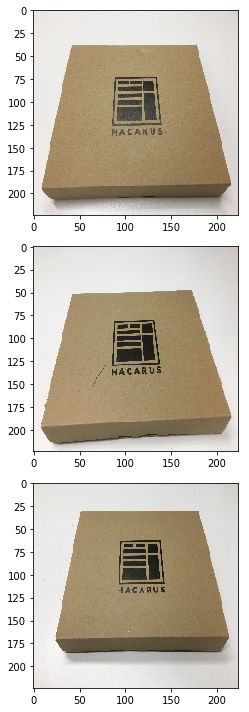

In [70]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
for idx, path in enumerate(false_positive_samples.iloc[0:3]["file_name"]):
    skimage.io.imshow(skimage.transform.resize(skimage.io.imread(path), (224, 224, 3)), ax=axes[idx])

上記に見られるように、

- 文字の印刷による欠け
- マジックによる線

など欠陥はわずかであり、人間でもすぐに見ても分からない程度である。  
そのため、これらの対策として

- より高解像度な画像をモデルの入力とする
- 文字のOCRからの出力を特徴量に加える

などの工夫が必要と推測される。

### Model Training Analysis

cosine lossによる学習が文献1の結果に反してcross entropyよりモデルパフォーマンスを悪化させた原因を考えるため、  
モデルの学習の過程を分析する。  

In [107]:
model_training = pd.concat(
    [
        pd.read_csv(path.joinpath("holdout/resul t.csv"), index_col=False).add_prefix(name) for name, path in model_dirs.items()
    ],
    axis=1
)

In [109]:
model_training.columns

Index(['resnet50_pretrainedUnnamed: 0', 'resnet50_pretrainedtrain_loss',
       'resnet50_pretrainedtrain_score', 'resnet50_pretrainedvalid_loss',
       'resnet50_pretrainedvalid_score',
       'resnet50_pretrained_cosineUnnamed: 0',
       'resnet50_pretrained_cosinetrain_loss',
       'resnet50_pretrained_cosinetrain_score',
       'resnet50_pretrained_cosinevalid_loss',
       'resnet50_pretrained_cosinevalid_score',
       'resnet50_pretrained_cosine_prunedUnnamed: 0',
       'resnet50_pretrained_cosine_prunedtrain_loss',
       'resnet50_pretrained_cosine_prunedtrain_score',
       'resnet50_pretrained_cosine_prunedvalid_loss',
       'resnet50_pretrained_cosine_prunedvalid_score'],
      dtype='object')

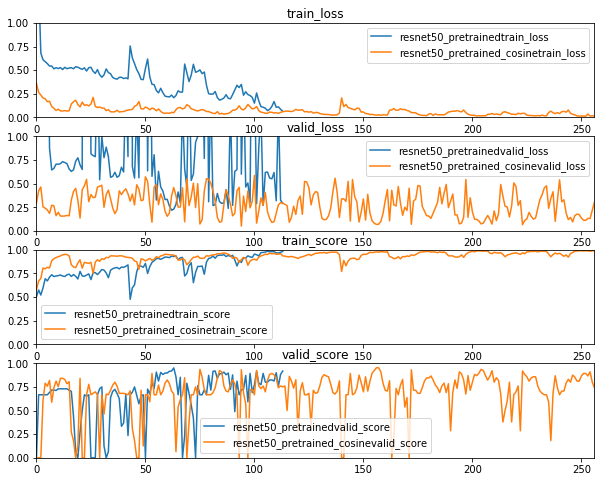

In [125]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 8))
for idx, loss_name in enumerate(["train_loss", "valid_loss", 
                                "train_score", "valid_score"]):
    axes[idx].title.set_text(loss_name)
    model_training.loc[:, 
                            ["resnet50_pretrained" + loss_name, 
                            "resnet50_pretrained_cosine" + loss_name
                           ]
        ].plot(ax=axes[idx], ylim=(0, 1))

ここでscoreはf1 scoreである。  
なおloss functionの大きさはそもそもcosine lossとcross entropy lossの定義が違うため、比較できない。
これらを見るとcosine lossでもcross entropy lossによる学習でも、  
validationのloss・scoreの値は大きく変動していることが分かる。  
さらにtrainデータとは異なり、validationのvalid scoreとf1 scoreの変動が必ずしも連動していないこともわかる。  
加えて、valid scoreの最大値にはほとんど差が見られない。 

これらの点を合わせて考えると、  
cross entropy lossとcosine lossによる性能差は、  
f1 scoreをearly stoppingの指標に使ったことが原因の可能性がある。  

これを検証するためには、early stoppingの指標にlossを使って再度比較する必要がある。  

## Conclusion

今回はこの検知モデルを作成し、テストデータのf1 scoreで0.9, roc aucで0.95と良好な結果を得た。  
ただし、cosine lossやweight pruningなど小さいサイズのデータセットに対策は
有効には働かなかった。 
加えて学習が不安定でもあり、何らかの結果を安定化させる方法が必要である。

さらに一部のわずかな欠損は認識するのが難しかった。  
これらに対しては別途対策が必要であると予想される。

## 参考文献

1. Barz, B., & Denzler, J. (2019). Deep Learning on Small Datasets without Pre-Training using Cosine Loss. Retrieved from http://arxiv.org/abs/1901.09054